Firstly, I used TPU and pretrained models because it is a huge dataset. During training, total ram usage of TPU (8 chips) has reached nearly 310 GB out of 330 GB. Although I used TPU, the training phases took a long time. I tried a custom CNN model and other pretrained models (InceptionV3,  MobileNetV2	, NASNetLarge, EfficientNetV2B3). However, I haven't obtained sufficient results in respect of accuracy and F1 score. I uploaded some of my models and weights[1].

<br>
<b> Finally, I combined the 2 most accurate models and created an ensemble model. </b> 

* <span style="color:#e74c3c;">  Model 1 ResNet50 </span> 100x100 images, 8 Epochs, 64 Batches
* <span style="color:#e74c3c;">  Model 2 Xception </span> 100x100 images, 5 Epochs, 64 Batches
* Ensemble Model (25 % ResNet50, 75 % Xception)

<br>

I have used the following methods.

* The project took place using <b>Google TPU</b>,
* Used tf.data for input pipeline,
* Custom callback class that is used for saving the model and weights at the end of each epoch[2]


## Test Set Predictions
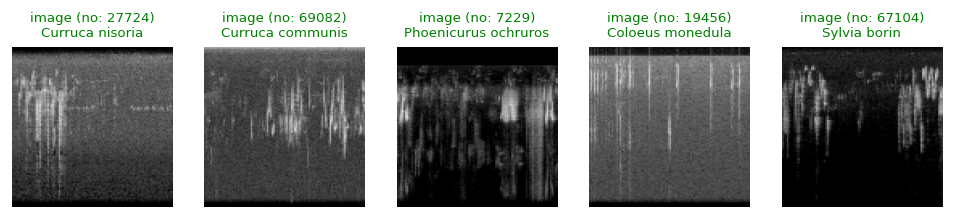
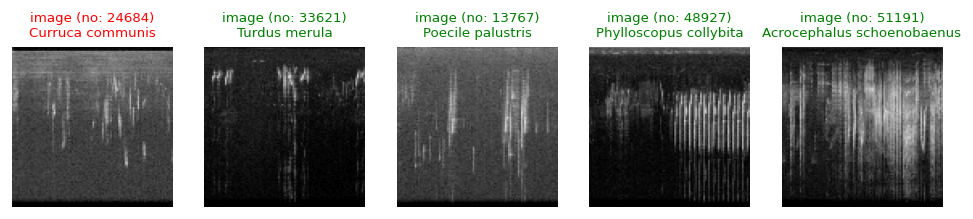
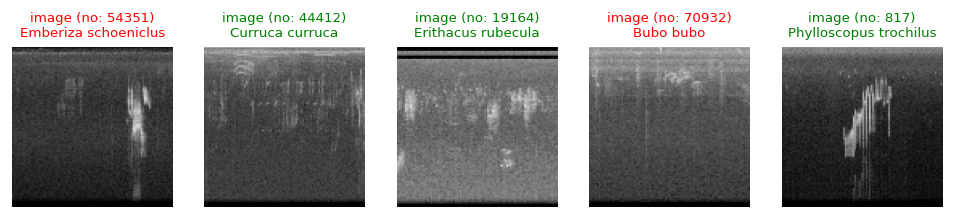


## My Another Projects
* [Higgs/Background Process Classification w/CNN,TPU](https://www.kaggle.com/code/banddaniel/higgs-background-process-classification-w-cnn-tpu)
* [Rice Classification w/Custom ResNet50 (ACC 85%)](https://www.kaggle.com/code/banddaniel/rice-classification-w-custom-resnet50-acc-85)
* [Lung Segmentation UNet w/SeparableConv (Dice:0.93)](https://www.kaggle.com/code/banddaniel/lung-segmentation-unet-w-separableconv-dice-0-93)
* [Plate Detection w/detectron2 (mAP@75: 89.19)](https://www.kaggle.com/code/banddaniel/plate-detection-w-detectron2-map-75-89-19)


## References
1. [Polish Bird Spectrograms My Models and Weights](https://www.kaggle.com/datasets/banddaniel/bird-sounds-h5)
2. My another custom callbacks for Tensorflow (https://github.com/john-fante/my-tensorflow-custom-callbacks)

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.applications import Xception,ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Activation, BatchNormalization, Dropout
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Model
from keras.utils.vis_utils import plot_model


SEED = 10
IMG_SIZE = 100,100
BATCH_SIZE = 64

D1008 22:25:10.829697322      14 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D1008 22:25:10.829735300      14 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D1008 22:25:10.829738847      14 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D1008 22:25:10.829741355      14 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D1008 22:25:10.829743699      14 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D1008 22:25:10.829746627      14 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D1008 22:25:10.829751227      14 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D1008 22:25:10.

In [2]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
stg = tf.distribute.TPUStrategy(tpu)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU

# <span style="color:#e74c3c;"> Preprocessing </span>


In [3]:
# Creating main dataframe contains image paths and their classes.

def create_images_list(path):
    full_path = []
    images = sorted(os.listdir(path))
    for i in images:
        full_path.append(os.path.join(path, i))
    return full_path


def create_full_img_class_df(full_path):
    data = pd.DataFrame()
    img_rows = []
    label_rows = []
    
    for i in range(len(full_path)):
        x = create_images_list(full_path[i])
        img_rows.extend(x)
        label_rows.extend([i]*len(x))
    
    data['img'] = img_rows
    data['label'] = label_rows
    
    return data


# look-up table
classes = {0: 'Accipiter gentilis', 1: 'Acrocephalus arundinaceus', 2: 'Acrocephalus paludicola', 3: 'Acrocephalus palustris', 4: 'Acrocephalus schoenobaenus', 5: 'Acrocephalus scirpaceus', 6: 'Aegolius funereus', 7: 'Alauda arvensis', 8: 'Alcedo atthis', 9: 'Anas platyrhynchos', 10: 'Anser anser', 11: 'Anser fabalis', 12: 'Anthus pratensis', 13: 'Anthus spinoletta', 14: 'Anthus trivialis', 15: 'Apus apus', 16: 'Ardea alba', 17: 'Ardea cinerea', 18: 'Asio otus', 19: 'Athene noctua', 20: 'Aythya ferina', 21: 'Bombycilla garrulus', 22: 'Botaurus stellaris', 23: 'Bubo bubo', 24: 'Bucephala clangula', 25: 'Buteo buteo', 26: 'Caprimulgus europaeus', 27: 'Carduelis carduelis', 28: 'Carpodacus erythrinus', 29: 'Certhia familiaris', 30: 'Charadrius dubius', 31: 'Chlidonias hybrida', 32: 'Chlidonias leucopterus', 33: 'Chlidonias niger', 34: 'Chloris chloris', 35: 'Chroicocephalus ridibundus', 36: 'Ciconia ciconia', 37: 'Circus aeruginosus', 38: 'Coccothraustes coccothraustes', 39: 'Coloeus monedula', 40: 'Columba oenas', 41: 'Columba palumbus', 42: 'Corvus corax', 43: 'Corvus cornix', 44: 'Corvus frugilegus', 45: 'Coturnix coturnix', 46: 'Crex crex', 47: 'Cuculus canorus', 48: 'Curruca communis', 49: 'Curruca curruca', 50: 'Curruca nisoria', 51: 'Cyanistes caeruleus', 52: 'Cygnus cygnus', 53: 'Cygnus olor', 54: 'Delichon urbicum', 55: 'Dendrocopos major', 56: 'Dendrocoptes medius', 57: 'Dryobates minor', 58: 'Dryocopus martius', 59: 'Emberiza calandra', 60: 'Emberiza citrinella', 61: 'Emberiza hortulana', 62: 'Emberiza schoeniclus', 63: 'Erithacus rubecula', 64: 'Falco tinnunculus', 65: 'Ficedula albicollis', 66: 'Ficedula hypoleuca', 67: 'Ficedula parva', 68: 'Fringilla coelebs', 69: 'Fulica atra', 70: 'Galerida cristata', 71: 'Gallinago gallinago', 72: 'Gallinago media', 73: 'Garrulus glandarius', 74: 'Glaucidium passerinum', 75: 'Grus grus', 76: 'Haematopus ostralegus', 77: 'Haliaeetus albicilla', 78: 'Hippolais icterina', 79: 'Hirundo rustica', 80: 'Jynx torquilla', 81: 'Lanius collurio', 82: 'Larus argentatus', 83: 'Limosa limosa', 84: 'Linaria cannabina', 85: 'Locustella fluviatilis', 86: 'Locustella luscinioides', 87: 'Locustella naevia', 88: 'Lophophanes cristatus', 89: 'Lullula arborea', 90: 'Luscinia luscinia', 91: 'Luscinia megarhynchos', 92: 'Luscinia svecica', 93: 'Lyrurus tetrix', 94: 'Mareca strepera', 95: 'Merops apiaster', 96: 'Motacilla alba', 97: 'Motacilla cinerea', 98: 'Motacilla flava', 99: 'Muscicapa striata', 100: 'Nucifraga caryocatactes', 101: 'Numenius arquata', 102: 'Oenanthe oenanthe', 103: 'Oriolus oriolus', 104: 'Panurus biarmicus', 105: 'Parus major', 106: 'Passer domesticus', 107: 'Passer montanus', 108: 'Perdix perdix', 109: 'Periparus ater', 110: 'Phalacrocorax carbo', 111: 'Phasianus colchicus', 112: 'Phoenicurus ochruros', 113: 'Phoenicurus phoenicurus', 114: 'Phylloscopus collybita', 115: 'Phylloscopus sibilatrix', 116: 'Phylloscopus trochilus', 117: 'Pica pica', 118: 'Picus viridis', 119: 'Podiceps cristatus', 120: 'Podiceps grisegena', 121: 'Poecile montanus', 122: 'Poecile palustris', 123: 'Porzana porzana', 124: 'Prunella modularis', 125: 'Pyrrhula pyrrhula', 126: 'Rallus aquaticus', 127: 'Regulus ignicapilla', 128: 'Regulus regulus', 129: 'Remiz pendulinus', 130: 'Riparia riparia', 131: 'Saxicola rubetra', 132: 'Scolopax rusticola', 133: 'Serinus serinus', 134: 'Sitta europaea', 135: 'Spatula querquedula', 136: 'Spinus spinus', 137: 'Sterna hirundo', 138: 'Streptopelia decaocto', 139: 'Streptopelia turtur', 140: 'Strix aluco', 141: 'Sturnus vulgaris', 142: 'Sylvia atricapilla', 143: 'Sylvia borin', 144: 'Tachybaptus ruficollis', 145: 'Tetrao urogallus', 146: 'Tetrastes bonasia', 147: 'Tringa glareola', 148: 'Tringa nebularia', 149: 'Tringa totanus', 150: 'Troglodytes troglodytes', 151: 'Turdus iliacus', 152: 'Turdus merula', 153: 'Turdus philomelos', 154: 'Turdus pilaris', 155: 'Turdus viscivorus', 156: 'Tyto alba', 157: 'Upupa epops', 158: 'Vanellus vanellus', 159: 'Zapornia parva'}


full_train_paths = create_images_list('/kaggle/input/160-populal-polish-bird-species-specterograms/dataset/train')
full_valid_paths = create_images_list('/kaggle/input/160-populal-polish-bird-species-specterograms/dataset/valid')
full_test_paths = create_images_list('/kaggle/input/160-populal-polish-bird-species-specterograms/dataset/test')

train_data = create_full_img_class_df(full_train_paths)
valid_data = create_full_img_class_df(full_valid_paths)
test_data = create_full_img_class_df(full_test_paths)

train_data = shuffle(train_data).reset_index(drop = True)
valid_data = shuffle(valid_data).reset_index(drop = True)
test_data = shuffle(test_data).reset_index(drop = True)

print("train images: ", train_data.shape[0])
print("validation images: ", valid_data.shape[0])
print("test images: ", test_data.shape[0])

train images:  1296299
validation images:  71809
test images:  71913


# <span style="color:#e74c3c;"> Creating </span> tf.data Pipeline

In [4]:
# Reading and resizing images

def img_preprocessing(img, label):
    img = tf.io.read_file(img)
    img = tf.io.decode_png(img, channels = 3)
    img = tf.image.resize(img, size = (IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    
    return img, label

In [5]:
# Creating dataset loaders and tf.datasets

train_loader = tf.data.Dataset.from_tensor_slices((train_data['img'], train_data['label']))
train_dataset = (train_loader
                 .map(img_preprocessing)
                 .shuffle(train_data.shape[0])
                 .batch(BATCH_SIZE)
                 .prefetch(BATCH_SIZE))

valid_loader = tf.data.Dataset.from_tensor_slices((valid_data['img'], valid_data['label']))
valid_dataset = (valid_loader
                 .map(img_preprocessing)
                 .batch(BATCH_SIZE)
                 .prefetch(BATCH_SIZE))


test_loader = tf.data.Dataset.from_tensor_slices((test_data['img'], test_data['label']))
test_dataset = (test_loader
                 .map(img_preprocessing)
                 .batch(BATCH_SIZE)
                 .prefetch(BATCH_SIZE))

# <span style="color:#e74c3c;"> Custom </span> Callback


In [6]:
# Custom callback used saving models for each epoch

# for example -> '/kaggle/input/bird-sounds-h5/model_ResNet50_8_100_64.h5'
# model_name -> ResNet50
# epochs -> 8
# img_size -> 100
# batch_size -> 64

class ModelSaveEachEpoch(Callback):
    def __init__(self, model_name, img_size, batch_size, **kwargs):
        super(ModelSaveEachEpoch, self).__init__(**kwargs)
        self.model_name = model_name
        self.img_size = img_size
        self.batch_size = batch_size

    
    def on_epoch_end(self, epochs, logs = None ):
        file_name = 'model_' + self.model_name  + '_' + str(epochs + 1) + '_' + str(self.img_size) + '_' + str(self.batch_size) + '.h5'
        eval_ = model.evaluate(test_dataset)
        model.save(file_name)
        print(' ----- model saved ----- ')

# <span style="color:#e74c3c;"> Model 1 </span> ResNet50


In [7]:
with stg.scope():
    model1 = tf.keras.saving.load_model('/kaggle/input/bird-sounds-h5/model_ResNet50_8_100_64.h5')
    
    train_eval1 = model1.evaluate(train_dataset)
    print('Train Loss: {0:.3f}'.format(train_eval1[0]))
    print('Train Accuracy: {0:.3f} %'.format(train_eval1[1]*100))
    print('-'*100)

    validation_eval1 = model1.evaluate(valid_dataset)
    print('Validation Loss: {0:.3f}'.format(validation_eval1[0]))
    print('Validation Accuracy: {0:.3f} %'.format(validation_eval1[1]*100))
    print('-'*100)

    test_eval1 = model1.evaluate(test_dataset)
    print('Test Loss: {0:.3f}'.format(test_eval1[0]))
    print('Test Accuracy: {0:.3f} %'.format(test_eval1[1]*100))

2023-10-08 22:27:20.420758: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-08 22:27:20.658854: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


20255/20255 [==============================] - 571s 17ms/step - loss: 0.7218 - accuracy: 0.8350
Train Loss: 0.722
Train Accuracy: 83.500 %
----------------------------------------------------------------------------------------------------
1123/1123 [==============================] - 26s 22ms/step - loss: 1.4544 - accuracy: 0.7302
Validation Loss: 1.454
Validation Accuracy: 73.019 %
----------------------------------------------------------------------------------------------------
1124/1124 [==============================] - 23s 19ms/step - loss: 1.4663 - accuracy: 0.7325
Test Loss: 1.466
Test Accuracy: 73.252 %


# <span style="color:#e74c3c;"> Model 1 </span> Classification Report

In [8]:
# Test Classification Report for Model 1

test_take1 =  test_dataset.take(-1)
test_take1_ = list(test_take1)
pred = model1.predict(test_take1)
pred_1 = np.argmax(pred, axis = 1)


clf_1 = classification_report(test_data['label'], pred_1, target_names = list(classes.values()))
print(clf_1)

2023-10-08 22:38:00.773608: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-08 22:38:00.997734: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


1124/1124 [==============================] - 31s 21ms/step
                               precision    recall  f1-score   support

           Accipiter gentilis       0.65      0.62      0.63       154
    Acrocephalus arundinaceus       0.98      0.83      0.90       463
      Acrocephalus paludicola       0.87      0.72      0.79        54
       Acrocephalus palustris       0.77      0.77      0.77      1413
   Acrocephalus schoenobaenus       0.83      0.64      0.72       653
      Acrocephalus scirpaceus       0.94      0.60      0.73       730
            Aegolius funereus       0.60      0.78      0.68       226
              Alauda arvensis       0.72      0.86      0.78       791
                Alcedo atthis       0.77      0.74      0.75        80
           Anas platyrhynchos       0.56      0.49      0.52       153
                  Anser anser       0.81      0.32      0.46       187
                Anser fabalis       1.00      0.05      0.10        19
             Anth

# <span style="color:#e74c3c;"> Model 2 </span> Xception


In [9]:
with stg.scope():
    model2 = tf.keras.saving.load_model('/kaggle/input/bird-sounds-h5/model_Xception_5_100_64.h5')

    train_eval2 = model2.evaluate(train_dataset)
    print('Train Loss: {0:.3f}'.format(train_eval2[0]))
    print('Train Accuracy: {0:.3f} %'.format(train_eval2[1]*100))
    print('-'*100)

    validation_eval2 = model2.evaluate(valid_dataset)
    print('Validation Loss: {0:.3f}'.format(validation_eval2[0]))
    print('Validation Accuracy: {0:.3f} %'.format(validation_eval2[1]*100))
    print('-'*100)

    test_eval2 = model2.evaluate(test_dataset)
    print('Test Loss: {0:.3f}'.format(test_eval2[0]))
    print('Test Accuracy: {0:.3f} %'.format(test_eval2[1]*100))

2023-10-08 22:38:58.599247: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-08 22:38:58.796897: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


20255/20255 [==============================] - 423s 15ms/step - loss: 0.4037 - accuracy: 0.8980
Train Loss: 0.404
Train Accuracy: 89.804 %
----------------------------------------------------------------------------------------------------
1123/1123 [==============================] - 22s 19ms/step - loss: 0.9606 - accuracy: 0.8005
Validation Loss: 0.961
Validation Accuracy: 80.048 %
----------------------------------------------------------------------------------------------------
1124/1124 [==============================] - 20s 17ms/step - loss: 0.9795 - accuracy: 0.7978
Test Loss: 0.979
Test Accuracy: 79.784 %


# <span style="color:#e74c3c;"> Model 2 </span> Classification Report

In [10]:
# Test Classification Report for Model 2

test_take1 =  test_dataset.take(-1)
test_take1_ = list(test_take1)
pred = model1.predict(test_take1)
pred_2 = np.argmax(pred, axis = 1)


clf_2 = classification_report(test_data['label'], pred_2, target_names = list(classes.values()))
print(clf_2)

1124/1124 [==============================] - 22s 19ms/step
                               precision    recall  f1-score   support

           Accipiter gentilis       0.65      0.62      0.63       154
    Acrocephalus arundinaceus       0.98      0.83      0.90       463
      Acrocephalus paludicola       0.87      0.72      0.79        54
       Acrocephalus palustris       0.77      0.77      0.77      1413
   Acrocephalus schoenobaenus       0.83      0.64      0.72       653
      Acrocephalus scirpaceus       0.94      0.60      0.73       730
            Aegolius funereus       0.60      0.78      0.68       226
              Alauda arvensis       0.72      0.86      0.78       791
                Alcedo atthis       0.77      0.74      0.75        80
           Anas platyrhynchos       0.56      0.49      0.52       153
                  Anser anser       0.81      0.32      0.46       187
                Anser fabalis       1.00      0.05      0.10        19
             Anth

# <span style="color:#e74c3c;"> Ensemble Model </span>


In [11]:
# (Base code) Average weighted layer from -> https://stackoverflow.com/questions/67647843/is-there-a-way-to-ensemble-two-keras-h5-models-trained-for-same-classes

class WeightedAverageLayer(Layer):
    def __init__(self, weight1, weight2, **kwargs):
        super(WeightedAverageLayer, self).__init__(**kwargs)
        self.weight1 = weight1
        self.weight2 = weight2

    def call(self, inputs):
        model1_result, model2_result = inputs
        final_res = self.weight1 * model1_result + self.weight2 * model2_result
        return final_res
    
    def get_config():
        base_config = super().get_config()
        
        return {
            **base_config,
            "weight1" : self.weight1,
            "weight2" : self.weight2
        }


# <span style="color:#e74c3c;"> Ensemble Model </span> Training

In [12]:
with stg.scope():
    model1._name = 'model_1'
    model2._name = 'model_2'
    models = [model1, model2]
    model_input = tf.keras.Input(shape=(*IMG_SIZE, 3))
    model_outputs = [model(model_input) for model in models]
    ensemble_output = WeightedAverageLayer(0.25, 0.75)(model_outputs)
    ensemble_model = Model(inputs=model_input, outputs=ensemble_output)    
    ensemble_model.compile(optimizer  = tf.keras.optimizers.Adam() , loss = 'sparse_categorical_crossentropy', metrics = ['acc'])
    ensemble_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_1 (Sequential)           (None, 160)          24812320    ['input_1[0][0]']                
                                                                                                  
 model_2 (Sequential)           (None, 160)          21428168    ['input_1[0][0]']                
                                                                                                  
 weighted_average_layer (Weight  (None, 160)         0           ['model_1[0][0]',            

In [13]:
hist = ensemble_model.fit(train_dataset, epochs = 2, validation_data = valid_dataset)

Epoch 1/2


2023-10-08 22:48:17.057777: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-08 22:48:18.684142: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


20255/20255 [==============================] - ETA: 0s - loss: 0.3973 - acc: 0.8889

2023-10-08 23:16:20.259114: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-08 23:16:20.603074: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


20255/20255 [==============================] - 1766s 77ms/step - loss: 0.3973 - acc: 0.8889 - val_loss: 1.0147 - val_acc: 0.7933
Epoch 2/2
20255/20255 [==============================] - 1590s 72ms/step - loss: 0.3711 - acc: 0.8951 - val_loss: 1.0009 - val_acc: 0.7968


# <span style="color:#e74c3c;"> Test </span> Prediction, Evaluation


In [14]:
with stg.scope():
    test_eval_final = ensemble_model.evaluate(test_dataset)
    print('Test Loss: {0:.3f}'.format(test_eval_final[0]))
    print('Test Accuracy: {0:.3f} %'.format(test_eval_final[1]*100))

1124/1124 [==============================] - 41s 36ms/step - loss: 1.0301 - acc: 0.7943
Test Loss: 1.030
Test Accuracy: 79.435 %


In [15]:
test_take1 =  test_dataset.take(-1)
test_take1_ = list(test_take1)
pred = ensemble_model.predict(test_take1)
pred_ = np.argmax(pred, axis = 1)

2023-10-08 23:45:02.465907: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-08 23:45:02.794599: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


1124/1124 [==============================] - 52s 33ms/step


# <span style="color:#e74c3c;"> Ensemble Model </span> Classification Report

In [16]:
# Test Classification Report for Ensemble Model

clf = classification_report(test_data['label'], pred_, target_names = list(classes.values()))
print(clf)

                               precision    recall  f1-score   support

           Accipiter gentilis       0.68      0.68      0.68       154
    Acrocephalus arundinaceus       0.93      0.86      0.90       463
      Acrocephalus paludicola       0.69      0.83      0.76        54
       Acrocephalus palustris       0.81      0.84      0.82      1413
   Acrocephalus schoenobaenus       0.85      0.77      0.81       653
      Acrocephalus scirpaceus       0.87      0.83      0.85       730
            Aegolius funereus       0.69      0.77      0.73       226
              Alauda arvensis       0.74      0.86      0.79       791
                Alcedo atthis       0.86      0.81      0.83        80
           Anas platyrhynchos       0.67      0.59      0.63       153
                  Anser anser       0.64      0.73      0.68       187
                Anser fabalis       0.62      0.53      0.57        19
             Anthus pratensis       0.61      0.51      0.56       142
     

# <span style="color:#e74c3c;"> Test Set </span> Predictions

In [17]:
# A function that creating 5 random images in the test set and predictions

# Red title -> a false prediction
# Green title -> a true prediction

def random_test_sample_with_prediction():
    idxs = np.random.permutation(len(pred_))[:5]
    batch_idx = idxs // BATCH_SIZE
    image_idx = idxs-batch_idx * BATCH_SIZE
    idx = idxs

    fig, axs = plt.subplots(1,5, figsize = (10,10) ,dpi = 120)

    for i in range(5):
        img = test_take1_[batch_idx[i]][0][image_idx[i]]
        label = test_take1_[batch_idx[i]][1][image_idx[i]].numpy()
        

        if int(pred_[idx[i]]) == label:
            axs[i].imshow(img , cmap = 'gray') 
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i])  + ')' + '\n' + classes[label], fontsize = 8, color = 'green')
        else:
            axs[i].imshow(img , cmap = 'gray')
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i])  + ')' + '\n' + classes[label], fontsize = 8, color = 'red')


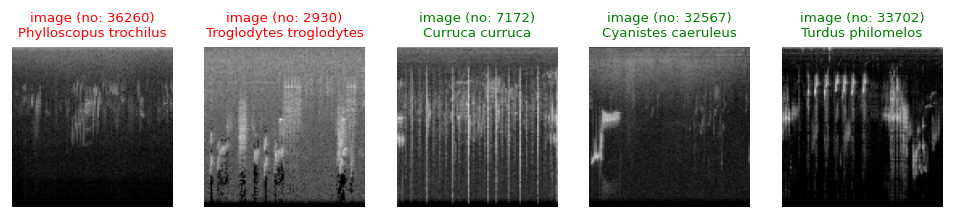

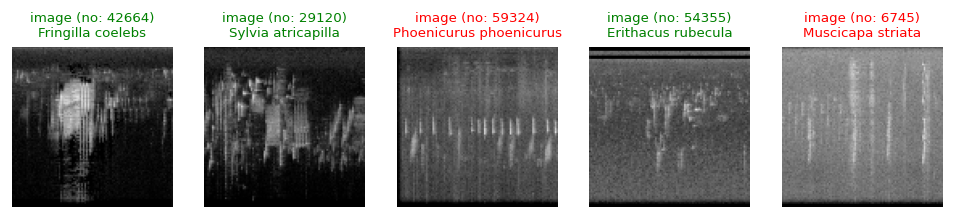

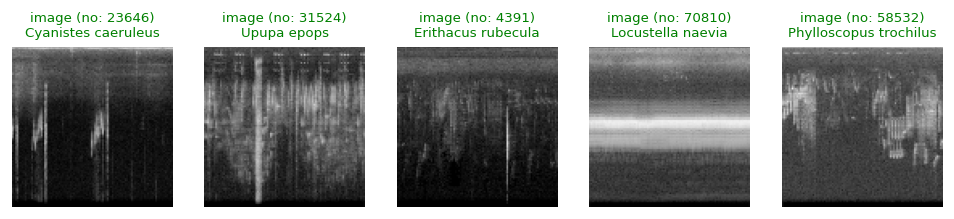

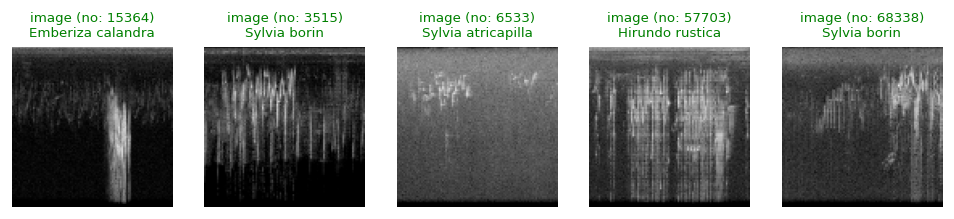

In [18]:
# Red title -> a false prediction
# Green title -> a true prediction

random_test_sample_with_prediction()
random_test_sample_with_prediction()
random_test_sample_with_prediction()
random_test_sample_with_prediction()